# Case Study: Explaining Spam Classification Using LIME

## 1. Getting started with Python and Jupyter Notebook

In this section, Jupyter Notebook and Python settings are initialized. 

In [1]:
# Notebook settings
###################

# resetting variables
get_ipython().magic('reset -sf') 

# formatting: cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# plotting
%matplotlib inline

## 2. Imports

We begin by initializing a seed for reproducibility. 

In [2]:
import random
random.seed(245)
random_state=245

Next we import all necessary libraries.

In [3]:
import glob
import os
import nltk
import numpy as np
import sys
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

import lime
from lime.lime_text import LimeTextExplainer

## 3. Import Data

We will be using the UCI YouTube Spam Collection Data Set, which can be downloaded under the following link: http://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection.

In [4]:
import pandas as pd

# insert path for CSV file location
path = '/content/data'
csvfiles = glob.glob(os.path.join(path, '*.csv'))
dataframes = [] 

for csvfile in csvfiles:
    df = pd.read_csv(csvfile, usecols=["CONTENT", "CLASS"])
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)
df.columns = ['content', 'class']
df.head(10)

,content,class
0,Nice song﻿,0
1,I love song ﻿,0
2,I love song ﻿,0
3,"860,000,000 lets make it first female to reach...",0
4,shakira is best for worldcup﻿,0
5,The best world cup song ever!!!!﻿,0
6,I love﻿,0
7,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1
8,Awesome ﻿,0
9,I like shakira..﻿,0


## 4. Duplicate Removal

In [5]:
# check for duplicates
duplicates = df[df.duplicated()]  #equivalent to keep = first. Duplicated rows, except the first entry, are marked as 'True'
print(len(duplicates))

196


In [6]:
# remove duplicates
df = df.drop_duplicates()
df.shape

(1760, 2)

In [7]:
# double check
df[df.duplicated(subset='content')]

,content,class


## 5. Basic Data Preprocessing

The dataset contains a lot of noise. We do not extensively clean the data, but perform a minimum amount of pre-processing, which includes substituting non-alphanumeric characters with whitespaces and normalizing URLs and numbers. 

In [8]:
import re

def preprocessor(text):
    #changing bad encodings back to apostrophe
    text = re.sub('&#39', '\'', text) 
    #replacing URL's with placeholder
    text = re.sub('http\S+', 'URL', text) 
    #replacing URL's with placeholder
    text = re.sub('www\S+', 'URL', text)
    #removing HTML markup
    text = re.sub('<br */>', ' ', text) 
    #removing HTML markup
    text = re.sub('<[^>]*>', ' ', text) 
    #replacing digits with placeholder
    text = re.sub('\d+', ' NUM ', text)
    #removing remaining noisy characters, smileys, punctuation
    text = re.sub('[\W_]+', ' ', text) 
    return text

df.content = df.content.apply(preprocessor)

In [9]:
# a quick check
df.head(10)

,content,class
0,Nice song,0
1,I love song,0
3,NUM NUM NUM lets make it first female to reac...,0
4,shakira is best for worldcup,0
5,The best world cup song ever,0
6,I love,0
7,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1
8,Awesome,0
9,I like shakira,0
10,Shakira Waka Waka LOVE THIS SONG,0


## 6. Data Analytics

### 6.1. A quick check of data structure¶

In [10]:
# imported data structure
df.shape

(1760, 2)

In [11]:
# columns in data
df.columns

Index(['content', 'class'], dtype='object')

In [12]:
# double-check first few entries 
df.head()

,content,class
0,Nice song,0
1,I love song,0
3,NUM NUM NUM lets make it first female to reac...,0
4,shakira is best for worldcup,0
5,The best world cup song ever,0


### 6.2. Basic linguistic analysis of YouTube comments

In [13]:
# we compute word counts per comment, by tokenizing by whitespace
df['word_count'] = df['content'].apply(lambda x: len(x.strip().split(" ")))
df[['content','class', 'word_count']].head(10)

,content,class,word_count
0,Nice song,0,2
1,I love song,0,3
3,NUM NUM NUM lets make it first female to reac...,0,17
4,shakira is best for worldcup,0,5
5,The best world cup song ever,0,6
6,I love,0,2
7,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,10
8,Awesome,0,1
9,I like shakira,0,3
10,Shakira Waka Waka LOVE THIS SONG,0,6


In [14]:
# summary statistics of word counts
print(df['word_count'].describe())

count    1760.000000
mean       16.021591
std        21.928085
min         1.000000
25%         4.000000
50%         8.000000
75%        17.000000
max       217.000000
Name: word_count, dtype: float64


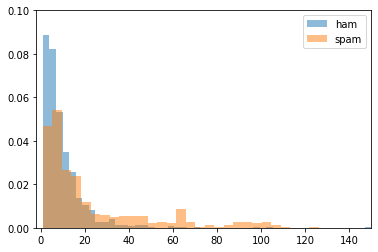

In [15]:
# show distribution of word counts per class
from matplotlib import pyplot

ham = df[df['class']==0]
spam = df[df['class']==1]

pyplot.hist(ham.word_count, bins=50, alpha=0.5, label='ham', density=True)
pyplot.hist(spam.word_count, bins=50, alpha=0.5, label='spam', density=True)
pyplot.xlim((-2,150))
pyplot.ylim((0,0.1))
pyplot.legend(loc='upper right')
pyplot.show()

In [16]:
# word counts per each class
print (ham['word_count'].describe())
print ()
print (spam['word_count'].describe())

count    919.000000
mean       9.405876
std       10.894903
min        1.000000
25%        3.000000
50%        6.000000
75%       12.000000
max      150.000000
Name: word_count, dtype: float64

count    841.000000
mean      23.250892
std       27.874251
min        1.000000
25%        6.000000
50%       12.000000
75%       30.000000
max      217.000000
Name: word_count, dtype: float64


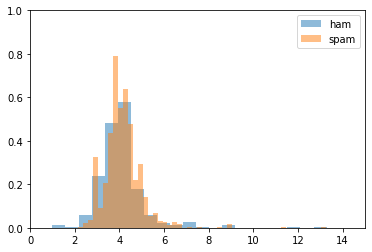

In [17]:
# average word length per comment
def avg_word(sentence):
    words = sentence.strip().split()
    return (sum(len(word) for word in words)/len(words)) if len(words) > 0 else 1


df['avg_word'] = df['content'].apply(avg_word)

ham = df[df['class']==0]
spam = df[df['class']==1]

# plotting histograms of average word length per each class
pyplot.hist(ham.avg_word, bins=50, alpha=0.5, label='ham', density=True)
pyplot.hist(spam.avg_word, bins=50, alpha=0.5, label='spam', density=True)
pyplot.xlim((0,15))
pyplot.ylim((0,1))
pyplot.legend(loc='upper right')
pyplot.show()

In [18]:
# average word length per class: summary statistics
print(ham.avg_word.describe())
print()
print(spam.avg_word.describe())

count    919.000000
mean       4.180942
std        1.903924
min        1.000000
25%        3.500000
50%        4.000000
75%        4.375000
max       30.250000
Name: avg_word, dtype: float64

count    841.000000
mean       4.171988
std        0.879561
min        2.166667
25%        3.727273
50%        4.066667
75%        4.500000
max       13.250000
Name: avg_word, dtype: float64


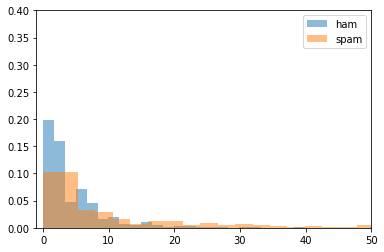

In [19]:
#stop word statistics - english stopwords from spacy
import spacy

nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

df['stopwords'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() in stopwords]))
df['stopwords_count'] = df['stopwords'].apply(lambda x: len(x.split()))

ham = df[df['class']==0]
spam = df[df['class']==1]

# stop words per comment: histograms per class
pyplot.hist(ham.stopwords_count, bins=50, alpha=0.5, label='ham', density=True)
pyplot.hist(spam.stopwords_count, bins=50, alpha=0.5, label='spam', density=True)
pyplot.xlim((-1,50))
pyplot.ylim((0,0.4))
pyplot.legend(loc='upper right')
pyplot.show()

In [20]:
# stop words per comment: summary statistics per class
print(ham.stopwords_count.describe())
print()
print(spam.stopwords_count.describe())

count    919.000000
mean       4.394995
std        6.169150
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       83.000000
Name: stopwords_count, dtype: float64

count    841.000000
mean      10.794293
std       14.567634
min        0.000000
25%        2.000000
50%        5.000000
75%       12.000000
max      133.000000
Name: stopwords_count, dtype: float64


## 7. Training Black Box Classifiers

We begin by splitting our data into a training and testing set.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=245)

In [22]:
# quick check of shapes
train.shape, test.shape

((1408, 6), (352, 6))

Next, we turn our textual data into numeric input, using sklearn's TF-IDF vectorizer. 

In [23]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()

#transform input data into numeric input
x_train = vectorizer.fit_transform(train.content)
y_train = train['class']
x_test = vectorizer.transform(test.content)
y_test = test['class']

In [24]:
# training data: shape
x_train.shape

(1408, 3166)

In [25]:
# test data: shape
x_test.shape

(352, 3166)

Now we are ready to train our classifiers. We will train a number of popular sklearn classifiers, using 10-fold cross-validation. We will then select the three best performing ones, to test Lime. 

Let's first import and store our classifiers in a list.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# prepare models
models = []
models.append(('RFC', RandomForestClassifier(random_state=random_state))) 
models.append(('XGB', XGBClassifier(random_state=random_state)))
models.append(('MLP', MLPClassifier(random_state=random_state, early_stopping= True)))

In [27]:
# hyper-parameter tuning: defining the space
parameter_space = {

    'RFC': {'n_estimators' : [10, 50, 100, 200, 300],  
             'max_depth' : [1, 3, 5, 10],  
             'max_features' :['auto', 'sqrt']},
    'XGB': {'n_estimators' : [10, 50, 100, 200, 300], 
            'max_depth' : [1, 3, 5, 10],  
            'colsample_bytree' : [0.5, 1] , 
            'learning_rate': [0.001, 0.01, 0.1, 1]},
    'MLP': { 'hidden_layer_sizes' :  [(10), (50), (100)], 
             'activation' :['tanh', 'relu'], 
             'learning_rate': ['constant','adaptive'], 
             'learning_rate_init': [1e-1, 1e-2, 1e-3]}}

In [ ]:
# running the grid search 
from sklearn.model_selection import GridSearchCV

models_tuned = []
results = []
names = []
scoring = 'roc_auc'

for name, model in models: 
    parameters = parameter_space[name]
    clf = GridSearchCV(model, 
                        parameters,  
                        cv = 10,
                        #cv=5, 
                        verbose=1,
                        scoring=scoring)
 
    clf.fit(x_train, y_train)

    # Best parameter set
    print('Best parameters for {} found:\n'.format(name), clf.best_params_)
    print('Mean train score: {:.3f}'.format(clf.best_score_))
    print('Standard Deviation {:.3f}'.format(clf.cv_results_['std_test_score'][clf.best_index_]))
    print()
    
    # All results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("{:.3f} (+/-{:.3f}) for {}".format(mean, std * 2, params))
    print()
    
    # Save results
    models_tuned.append((name, clf.best_params_))
    results.append(means)
    names.append(name)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished


Best parameters for RFC found:
 {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300}
Mean train score: 0.974
Standard Deviation 0.009

0.784 (+/-0.119) for {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 10}
0.907 (+/-0.091) for {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 50}
0.941 (+/-0.061) for {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 100}
0.949 (+/-0.041) for {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 200}
0.955 (+/-0.037) for {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 300}
0.784 (+/-0.119) for {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 10}
0.907 (+/-0.091) for {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 50}
0.941 (+/-0.061) for {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100}
0.949 (+/-0.041) for {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 200}
0.955 (+/-0.037) for {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 300}
0.875 (+/-0.079) for {'max_de

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# computing the performance of the best models on test data

import copy

#reinitialize models with best parameters
clf1 = copy.deepcopy(models[0][1]).set_params(**models_tuned[0][1])
clf2 = copy.deepcopy(models[1][1]).set_params(**models_tuned[1][1])
clf3 = copy.deepcopy(models[2][1]).set_params(**models_tuned[2][1])

clf1.fit(x_train, y_train)
clf2.fit(x_train, y_train)
clf3.fit(x_train, y_train)

pred1 = clf1.predict_proba(x_test)[:, 1]
pred2 = clf2.predict_proba(x_test)[:, 1]
pred3 = clf3.predict_proba(x_test)[:, 1]

print ("Roc_Auc Score RFC: ", sklearn.metrics.roc_auc_score(y_test, pred1))
print ("Roc_Auc Score XGB: ", sklearn.metrics.roc_auc_score(y_test, pred2))
print ("Roc_Auc Score MLP: ", sklearn.metrics.roc_auc_score(y_test, pred3))

In [ ]:
# best RFC model: additional performance measures
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, clf1.predict(x_test))
precision = precision_score(y_test, clf1.predict(x_test))
recall = recall_score(y_test, clf1.predict(x_test), average='macro')

# we print the measures on test data
#print('Test AUC:', auc_res)
print('Precision', precision)
print('Recall', recall)
print('Accuracy', accuracy)

In [ ]:
# best XGB model: additional performance measures
accuracy = accuracy_score(y_test, clf2.predict(x_test))
precision = precision_score(y_test, clf2.predict(x_test))
recall = recall_score(y_test, clf2.predict(x_test), average='macro')

# we print the measures on test data
#print('Test AUC:', auc_res)
print('Precision', precision)
print('Recall', recall)
print('Accuracy', accuracy)

In [ ]:
# best MLP model: additional performance measures
accuracy = accuracy_score(y_test, clf3.predict(x_test))
precision = precision_score(y_test, clf3.predict(x_test))
recall = recall_score(y_test, clf3.predict(x_test), average='macro')

# we print the measures on test data
#print('Test AUC:', auc_res)
print('Precision', precision)
print('Recall', recall)
print('Accuracy', accuracy)

## 8. Explaining Predictions Using LIME

In the following, we will analyze how LIME performs, when changing the following variables: sample size, number of features, tyoe of classifier, text length, and presence of stopwords. 

We first define our class names, which we pass as argument to our explainer object. 

As sklearn uses vectorized input, but LIME assumes raw text input, we use sklearn's pipeline, which can apply a sequence of transformations. 

In [ ]:
# We continue by considering only the RFC and XGB (best) classifiers
pipe_rfc = make_pipeline(vectorizer, clf1)
pipe_xgb = make_pipeline(vectorizer, clf2)

In [ ]:
# RFC pipeline
pipe_rfc

## 9. LIME Output Generation  

We select three distinct instances/comments and we generate LIME explanations using the RFC and XGB (best) classifiers. Finally, we test different methods to visualize the LIME explanations.

In [ ]:
# selection of the three instances/comments to be explained
#----------------------------------------------------------
#1.  (spam) idx = 4
#2.  (spam) idx = 350 
#3.   (ham) idx = 276 

In [ ]:
# choose the instance/comment
idx = 

In [ ]:
# chosen instance/comment
test['content'].iloc[idx]

In [ ]:
# before computing LIME explanations: summary
idx=idx
pipeline = pipe_rfc

print("Instance to be explained:")
#print(orig1)
print(test['content'].iloc[idx])
print("Actual class: ", test['class'].iloc[idx])
print('Predicted probability class 0 =', pipeline.predict_proba([test['content'].iloc[idx]])[0,0])
print('Predicted probability class 1 =', pipeline.predict_proba([test['content'].iloc[idx]])[0,1])

In [ ]:
# define class names for easier identification 
class_names = ['ham', 'spam']

In [ ]:
# default LimeTextExplainer()
random_state=245
class_names = ['ham', 'spam']
explainer = LimeTextExplainer(class_names=class_names, 
                              feature_selection='none',
                              random_state=random_state) 

In [ ]:
# computing the explanation (change the number of features accordingle)
explainer.random_state.seed(245)
exp = explainer.explain_instance(test['content'].iloc[idx],
                                 pipeline.predict_proba,
                                 #num_features=10,
                                 num_samples=500)

In [ ]:
# explanation as a list
exp.as_list()

In [ ]:
# explanation: intercept
exp.intercept

In [ ]:
# showing the explanation in a notebook
exp.show_in_notebook(text=True)

In [ ]:
# plotting the explanation
%matplotlib inline
fig = exp.as_pyplot_figure()
#fig.savefig('INSERT PATH', bbox_inches = "tight")

In [ ]:
# end of notebook